In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
import seaborn as sns
from sklearn.inspection import permutation_importance

In [2]:
# only look at data with correct true id 
bg = pd.read_csv('filtered_data/filtered_bg_2018.csv') # also filter out mother id
sig = pd.read_csv('filtered_data/filtered_sig_2018.csv')

In [6]:
# Step1: Prepare Data 

# Select some important features
not_important_features = np.loadtxt('features/not_important_features.txt', dtype=str)
not_important_features2 = np.loadtxt('features/not_important_features2.txt', dtype=str)
not_important_features3 = np.loadtxt('features/not_important_features3.txt', dtype=str)
not_important_features = list(np.concatenate((not_important_features, not_important_features2, not_important_features3), axis=0))
boolean_columns = sig.select_dtypes(include=['bool']).columns
manuel_selected_feature = ['_TRUE', 'ID', 'TRUEID', 'Polarity', 'MOTHER_ID', 'NDOF', 'Number'] + boolean_columns.tolist()

for feature in manuel_selected_feature:
    f = bg.filter(like=feature).columns
    for j in range(0, len(f)):
        not_important_features.append(f'{f[j]}')

X_signal = sig.loc[:, ~sig.columns.isin(not_important_features)] 
X_background = bg.loc[:, ~bg.columns.isin(not_important_features)] 
print('removed feature:', not_important_features)
print('signal shape:', X_signal.shape)
print('background shape:', X_background.shape)

# Assign labels: 1 for signal, 0 for background
y_signal = np.ones(len(X_signal))  
y_background = np.zeros(len(X_background))  

# Combine both datasets
X = pd.concat([X_signal, X_background], axis=0) # features
y = np.concatenate([y_signal, y_background], axis=0) # label


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Noramlise features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # Normalize features
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

removed feature: [np.str_('mu_minus_ETA'), np.str_('mu_plus_ETA'), np.str_('mu_minus_PX'), np.str_('B0_pmu_TR4_PX'), np.str_('mu_plus_PX'), np.str_('mu_plus_AtVtx_PX'), np.str_('B0_pmu_TR3_PX'), np.str_('B0_PX'), np.str_('kstar_PX'), np.str_('mu_minus_AtVtx_PX'), np.str_('pion_PX'), np.str_('B0_pmu_TR1_PX'), np.str_('kaon_PX'), np.str_('B0_pmu_TR2_PX'), np.str_('B0_PY'), np.str_('mu_plus_AtVtx_PY'), np.str_('kaon_PY'), np.str_('mu_minus_PY'), np.str_('B0_pmu_TR3_PY'), np.str_('B0_pmu_TR1_PY'), np.str_('pion_PY'), np.str_('kstar_PY'), np.str_('B0_pmu_TR2_PY'), np.str_('mu_minus_AtVtx_PY'), np.str_('mu_plus_PY'), np.str_('B0_pmu_TR4_PY'), np.str_('mu_plus_PZ'), np.str_('kaon_PZ'), np.str_('mu_minus_PZ'), np.str_('pion_PZ'), np.str_('B0_pmu_TR4_PZ'), np.str_('kstar_PZ'), np.str_('mu_minus_AtVtx_PZ'), np.str_('mu_plus_AtVtx_PZ'), np.str_('B0_pmu_TR2_PZ'), np.str_('B0_pmu_TR3_PZ'), np.str_('B0_PZ'), np.str_('B0_pmu_TR1_PZ'), np.str_('kstar_ENDVERTEX_CHI2'), np.str_('jpsi_ENDVERTEX_CHI2'), n

In [7]:
# Step2: Define the Model 
# FCNN: feedforward fully connected neural network

class Model(nn.Module):

    def __init__(self, n_inputs): # input: features 

        super(Model, self).__init__()

        # Hidden layers:
        self.hidden1 = nn.Linear(n_inputs, 20) # hidden size
        #self.bn1 = nn.BatchNorm1d(25) 
        self.activ1  = nn.ReLU()
        self.hidden2 = nn.Linear(20, 8)
        #self.bn2 = nn.BatchNorm1d(12)
        #self.activ2  = nn.ReLU()
        #self.hidden3 = nn.Linear(12, 5)
        #self.bn3 = nn.BatchNorm1d(5)
        self.activ3  = nn.ReLU()
        self.hidden4 = nn.Linear(8, 1)
        self.activ4  = nn.Sigmoid()

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        #X = self.bn1(X)
        X = self.activ1(X)
        # second hidden layer
        X = self.hidden2(X)
        #X = self.bn2(X)
        #X = self.activ2(X)
        # third hidden layer
        #X = self.hidden3(X)
        #X = self.bn3(X)
        X = self.activ3(X)
        # fourth hidden layer and output 
        X = self.hidden4(X)
        X = self.activ4(X) 
        return X

# Instantiate the model
input_dim = X_train.shape[1]  # Number of features
model = Model(input_dim)

In [8]:
#Step3: Train the Model

# Track the time
import time 
start_time = time.time()

alpha = 0.001 # learning rate
# Define loss and optimizer with class weight
criterion = nn.BCELoss()  # Binary cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=alpha) # Adam Optimizer is a good default choice for tabular data 

# Initialize lists to store loss values
history = {'loss': [], 'val_loss': [], 'recall': [], 'precision': []}
epochs = []
threshold_values = []

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    model.train() # set the model to traning mode
    optimizer.zero_grad()
    outputs = model(X_train_tensor) # get predicted value from training set 
    loss = criterion(outputs, y_train_tensor) 
    loss.backward() # compute the gradient of the loss with respect to weight and bias
    optimizer.step()

    # Store the training loss
    if epoch % 100 == 0:
        history['loss'].append(loss.item()) 

    # Calculate validation loss, recall, and precision every 100 epochs
    model.eval()  # Set the model to evaluation mode

    if epoch % 100 == 0:
        epochs.append(epoch)
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

        f1 = [] # create a list to store all f1 score to find the best threshold value
        with torch.no_grad():
            # find the best threshold that give the highest f1 value 
            for thresh in np.linspace(0.2, 0.6, 50):
                outputs = model(X_test_tensor).squeeze()
                predictions = (outputs > thresh).float()
                f1.append(f1_score(y_test_tensor, predictions))
            threshold_value = np.linspace(0.2, 0.6, 50)[np.argmax(f1)]
            threshold_values.append(threshold_value)

            # Store the validation loss
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
            history['val_loss'].append(val_loss.item())

            # Calculate recall and precision
            val_predictions = (val_outputs > threshold_value).float()
            recall = recall_score(y_test_tensor, val_predictions)
            precision = precision_score(y_test_tensor, val_predictions)
            history['recall'].append(recall)
            history['precision'].append(precision)


current_time = time.time()
print(f"Training time: {current_time - start_time:.2f} seconds")

Epoch [0/2000], Loss: 0.7581
Epoch [100/2000], Loss: 0.5130
Epoch [200/2000], Loss: 0.4721
Epoch [300/2000], Loss: 0.4530
Epoch [400/2000], Loss: 0.4377
Epoch [500/2000], Loss: 0.4263
Epoch [600/2000], Loss: 0.4205
Epoch [700/2000], Loss: 0.4172
Epoch [800/2000], Loss: 0.4152
Epoch [900/2000], Loss: 0.4133
Epoch [1000/2000], Loss: 0.4111
Epoch [1100/2000], Loss: 0.4090
Epoch [1200/2000], Loss: 0.4069
Epoch [1300/2000], Loss: 0.4050
Epoch [1400/2000], Loss: 0.4033
Epoch [1500/2000], Loss: 0.4022
Epoch [1600/2000], Loss: 0.4013
Epoch [1700/2000], Loss: 0.4007
Epoch [1800/2000], Loss: 0.4001
Epoch [1900/2000], Loss: 0.3996
Training time: 209.73 seconds


threshold probability at different epoch: [np.float64(0.2), np.float64(0.28979591836734697), np.float64(0.33061224489795915), np.float64(0.33061224489795915), np.float64(0.3469387755102041), np.float64(0.3551020408163265), np.float64(0.3469387755102041), np.float64(0.3469387755102041), np.float64(0.363265306122449), np.float64(0.3469387755102041), np.float64(0.3551020408163265), np.float64(0.3469387755102041), np.float64(0.3469387755102041), np.float64(0.3469387755102041), np.float64(0.33061224489795915), np.float64(0.3224489795918367), np.float64(0.33061224489795915), np.float64(0.3387755102040816), np.float64(0.3469387755102041), np.float64(0.3469387755102041)]


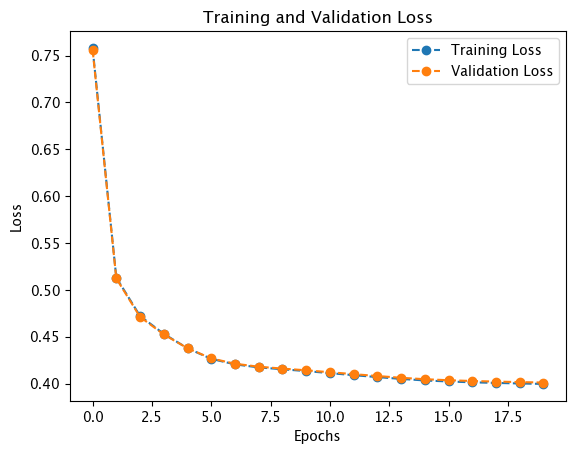

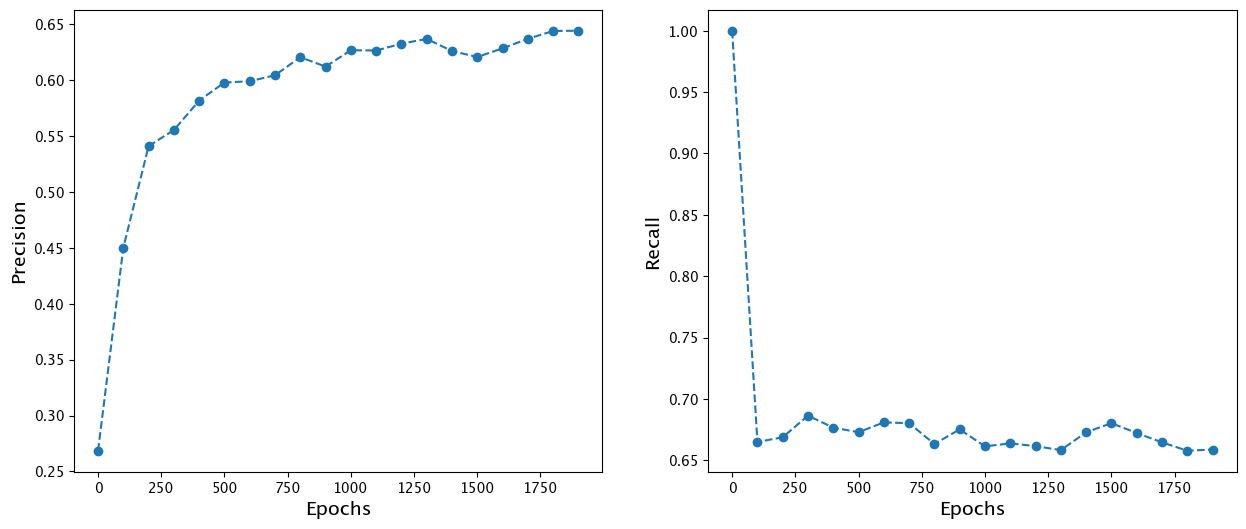

In [10]:
# Step3 added: shows graphs for permanance at different epochs
print('threshold probability at different epoch:', threshold_values)

# Plot Loss Curve
plt.figure()
plt.plot(history['loss'], 'o--', label='Training Loss')
plt.plot(history['val_loss'],'o--',  label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('plots/epoch_vs_loss.png', dpi=1000)
plt.show()

# Plot epoch vs recall
fig, axs = plt.subplots(1,2, figsize=(15,6))
axs[0].plot(epochs, history['precision'], 'o--')
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Precision', fontsize=14)

axs[1].plot(epochs, history['recall'], 'o--')
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Recall', fontsize=14)
plt.savefig('plots/epoch_vs_recall_precision.png', dpi=1000)
plt.show()

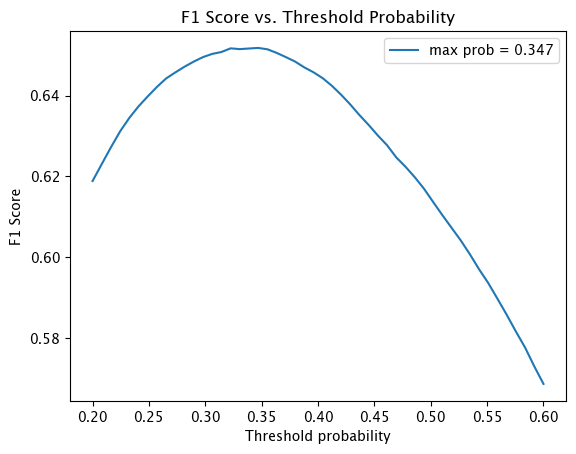

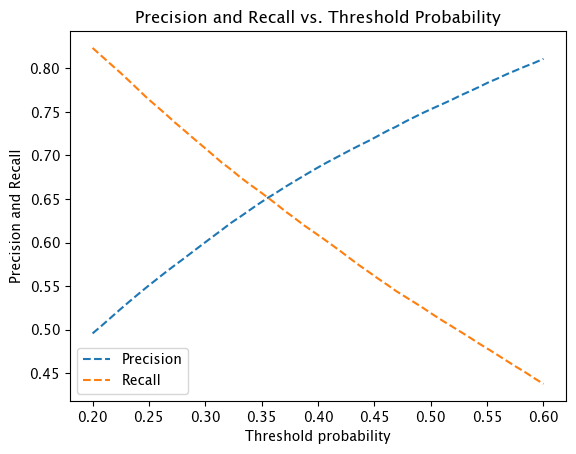

Accuracy: 0.8107
Precision: 0.6441
Recall: 0.6598
F1 Score: 0.6518
ROC AUC: 0.8516


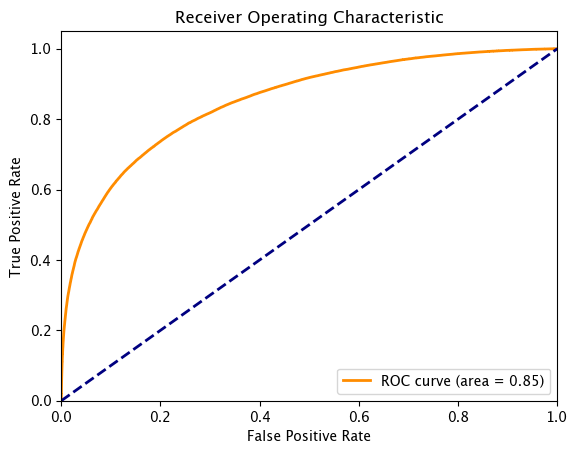

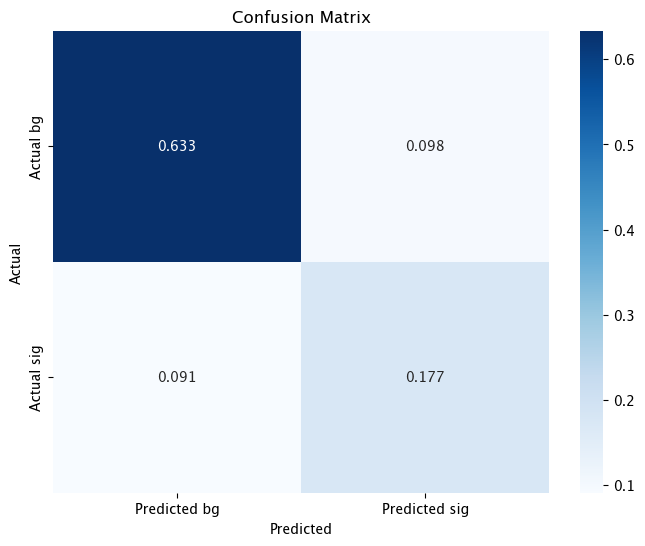

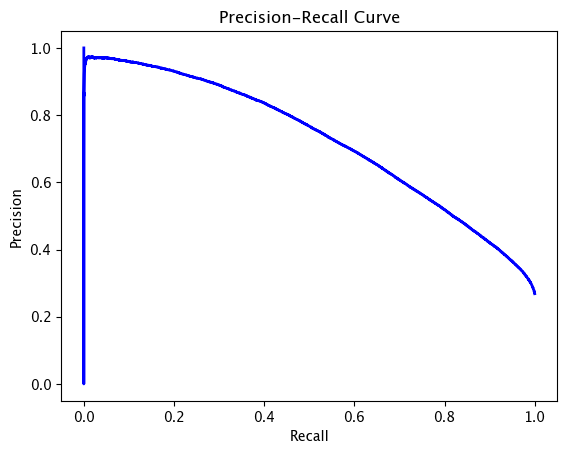

In [11]:
# Step 4: Evaluate the Model

# Set the model to evaluation mode
model.eval()

# find the best threshold that give the highest f1 value 
threshold = np.linspace(0.2, 0.6, 50)
f1 = []
precision = []
for thresh in threshold:
    with torch.no_grad(): # no need to further update the gradient
    # Get model predictions on the test set
        outputs = model(X_test_tensor).squeeze()
        predictions = (outputs > thresh).float()
        f1.append(f1_score(y_test_tensor, predictions))
        precision.append(precision_score(y_test_tensor, predictions))
plt.plot(threshold, f1, label=f'max prob = {threshold[np.argmax(f1)]:.3f}')
plt.xlabel('Threshold probability')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold Probability')
plt.legend()
plt.savefig('plots/f1_threshold.png', dpi=1000)
plt.show()


# set a probability threshold value for 1 and 0 
#threshold = len(sig) / (len(bg)+len(sig))
threshold_value = threshold[np.argmax(f1)]
precision = []
recall = []
for thresh in threshold:
    with torch.no_grad():
        # precision and recall curve at different threshold
        outputs = model(X_test_tensor).squeeze()
        predictions = (outputs > thresh).float()
        precision.append(precision_score(y_test_tensor, predictions))
        recall.append(recall_score(y_test_tensor, predictions))
plt.plot(threshold, precision, '--', label='Precision')
plt.plot(threshold, recall, '--', label='Recall')
plt.xlabel('Threshold probability')
plt.ylabel('Precision and Recall')
plt.title('Precision and Recall vs. Threshold Probability')
plt.legend()
plt.savefig('plots/precision_recall_threshold.png', dpi=1000)
plt.show()



# Disable gradient calculation
with torch.no_grad(): # no need to further update the gradient
    # Get model predictions on the test set
    outputs = model(X_test_tensor).squeeze()
    predictions = (outputs > threshold_value).float()

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_tensor, predictions) 
    precision = precision_score(y_test_tensor, predictions) # precision = TP / (TP+)
    recall = recall_score(y_test_tensor, predictions) # recall = TP / (TP+FN)
    f1 = f1_score(y_test_tensor, predictions)
    roc_auc = roc_auc_score(y_test_tensor, outputs)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    # save performance scores to dataframe
    scores = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC AUC': [roc_auc]
        }
    scores = pd.DataFrame(scores)
    scores.to_csv('scores.csv', index=False)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test_tensor, outputs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('plots/roc_curve.png', dpi=1000)
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test_tensor, predictions)
    plt.figure(figsize=(8, 6))
    cm = cm/np.sum(cm)
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['Predicted bg', 'Predicted sig'], yticklabels=['Actual bg', 'Actual sig'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('plots/confusion_matrix.png', dpi=1000)
    plt.show()

    # Plot Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test_tensor, outputs)
    plt.figure()
    plt.plot(recall_vals, precision_vals, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig('plots/precision_recall_curve.png', dpi=1000)
    plt.show()